In [42]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
from scipy.stats import lognorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import spinmob as sp

 Creating /Users/dchen/.spinmob/settings.txt



In [21]:
dfile = os.path.join(DATA_PATH, 'eorsky_3.00hours_Nside128_sigma0.03_fwhm12.13_uv.uvh5')
uvd = UVData()
uvd.read(dfile)

print(uvd.get_antpairs())
print(uvd.Nbls,uvd.Nfreqs, uvd.Nspws, uvd.Ntimes)
#print(dir(uvd))

Telescope eorsky is not in known_telescopes.


[(0, 11), (0, 12), (11, 12)]
3 384 1 982


In [22]:
cosmo = hp.conversions.Cosmo_Conversions()
print(cosmo)

Cosmo_Conversions object at <0x1c25e9ef98>
Om_L : 0.6844; Om_b : 0.0491; Om_c : 0.2644; Om_M : 0.3135; Om_k : 0.0021; H0 : 67.2700


In [23]:
# Creating the beamfile
beam_freqs = uvd.freq_array # in Hz
uvb = hp.PSpecBeamGauss(fwhm=0.21170844, beam_freqs=beam_freqs[0])

In [24]:
# Converting units
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='pI')
uvd.data_array *= Jy_to_mK[None, None, :, None]

In [25]:
# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)         #even
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)          #odd

# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

In [26]:
ds.rephase_to_dset(0)

In [27]:
# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

In [28]:
# Specify which baselines to include
baselines = [(0, 11), (0, 12), (11, 12)]

In [29]:
# Define uvp
# Polarization pairs for this specific simulation data is 'pI'
# spw_range length = number of delays
uvp = ds.pspec(baselines, baselines, (0, 1), [('pI', 'pI')], spw_ranges=(0, 200), input_data_weight='identity',
               norm='I', taper='blackman-harris', verbose=True)   


Setting spectral range: (0, 200)

Using polarization pair: ('pI', 'pI')

(bl1, bl2) pair: ((0, 11), (0, 11))
pol: (1, 1)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((0, 12), (0, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 12), (11, 12))
pol: (1, 1)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


Text(0.5, 1.0, 'spw : 0, blpair : ((0, 11), (0, 11)), pol : pI')

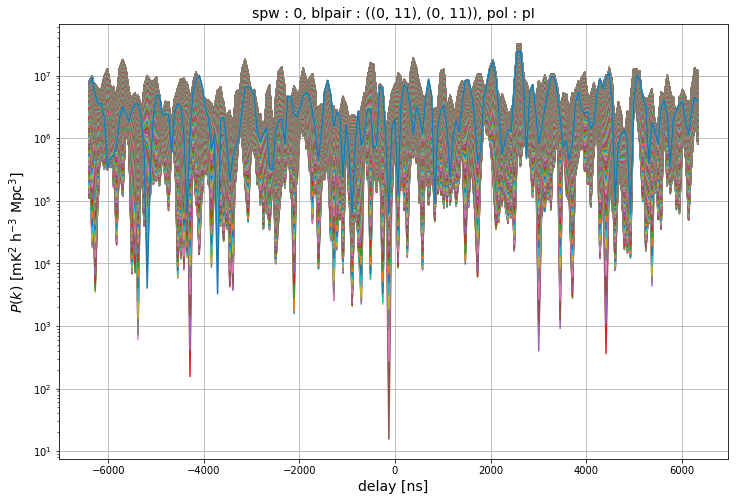

In [30]:
# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((0, 11), (0, 11))
key = (spw, blp, 'pI')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))

p1 = ax.plot(dlys, power.T)
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

Text(0.5, 1.0, 'spw : 0, blpair : ((0, 11), (0, 11)), pol : pI')

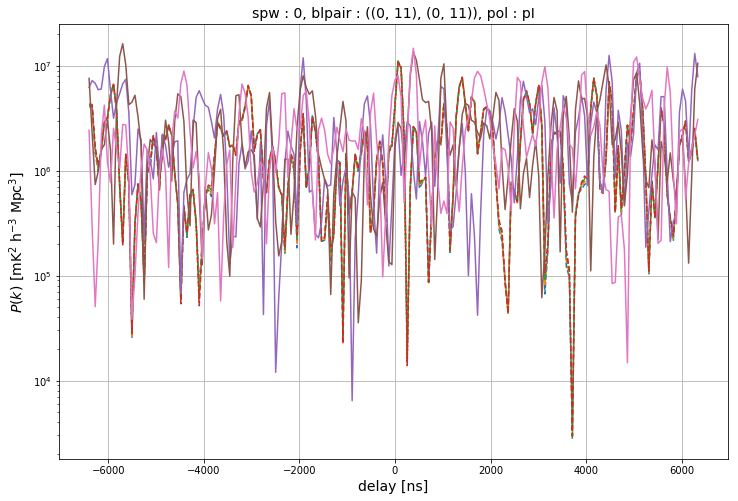

In [53]:
def select_time_range(ini_t, fin_t):
    p = []
    for i in range(int(fin_t-ini_t)+1):
        p.append(power[int(i+ini_t)])
    return np.transpose(p)

def select_diff_time(time):
    p = []
    for i in range(len(time)):
        p.append(power[int(i+time[i])])
    return np.transpose(p)

p1 = select_time_range(0, 3)
p2 = select_diff_time([100, 200, 300])
fig, ax = plt.subplots(figsize=(12,8))
_ = ax.plot(dlys, p1, '--')
ax.plot(dlys, p2, '-')
# ax.plot(dlys, power.T[:,0:3])
ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

In [32]:
# form the baseline-pair group, which will be a single group 
# consisting of all baseline-pairs in the object
blp_group = [sorted(np.unique(uvp.blpair_array))]

# average spectra with inplace = False and assign to a new "uvp2" object
uvp2 = uvp.average_spectra(blpair_groups=blp_group, time_avg=True, inplace=False)

Text(0.5, 1.0, 'spw : 0, blpair : ((0, 11), (0, 11)), pol : pI')

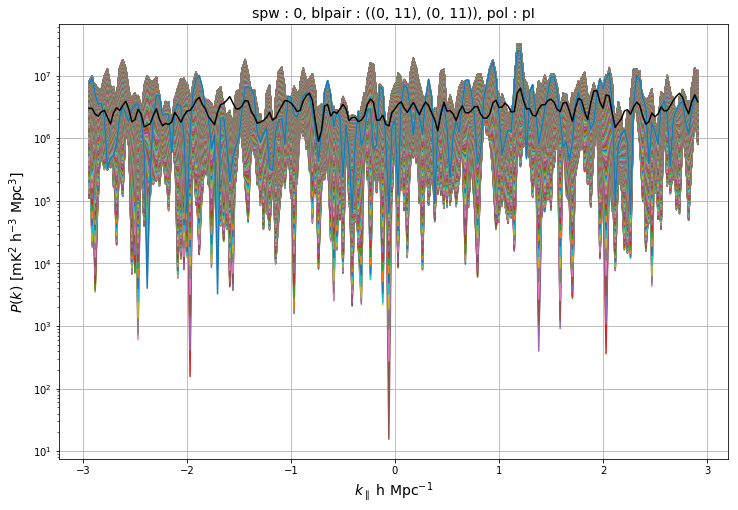

In [33]:
# plot power spectrum of spw 0
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((0, 11), (0, 11))
pol = 'pI'
key = (spw, blp, pol)
k_para = uvp.get_kparas(spw)
power = np.abs(np.real(uvp.get_data(key)))

avg_power = np.abs(np.real(uvp2.get_data(key)))

_ = ax.plot(k_para, power.T)
ax.plot(k_para, avg_power.T, color='k')
ax.set_yscale('log')
ax.grid()
ax.set_xlabel(r"$k_\parallel\ \rm h\ Mpc^{-1}$", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)

In [34]:
# return the nearest delay (in the dlys array) from the rough input delay
def get_delay(dly, key):
    dlys = uvp.get_dlys(key[0]) * 1e9
    dlys = np.asarray(dlys)
    idx = (np.abs(dlys - dly)).argmin()
    return dlys[idx]

In [35]:
# create a list of P(k) in a chosen delay interval or at a specific delay
def power_hist(i_dly, f_dly, key):
    power = np.real(uvp.get_data(key))
    ini_dly = get_delay(i_dly, key)
    fin_dly = get_delay(f_dly, key)
    dlys = uvp.get_dlys(key[0]) * 1e9
    i_index = int(np.where(dlys == ini_dly)[0])
    f_index = int(np.where(dlys == fin_dly)[0])
    y = []
    for i in range(int(f_index-i_index)+1):
        for j in range(len(power[i])):
            y.append(power[int(i+i_index)][j])
    return(y)

Text(0.5, 1.0, 'spw : 0, blpair : ((0, 11), (0, 11)), pol : pI, dlys : -1024ns ~ 1984ns')

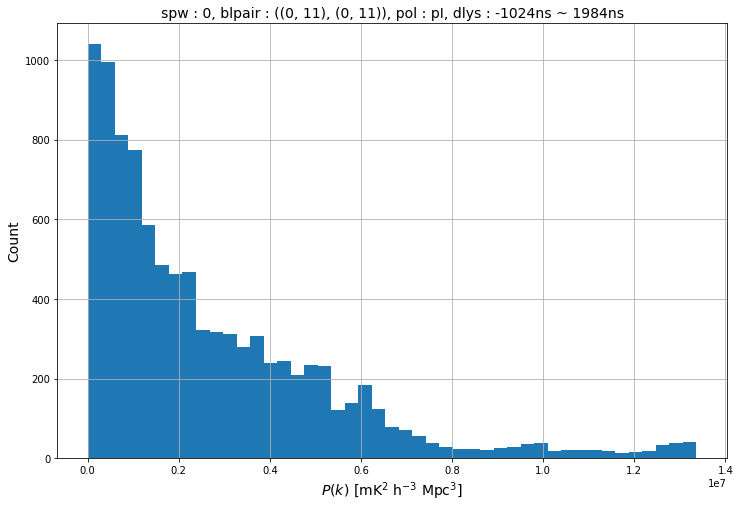

In [36]:
# plot a histogram of P(k)
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((0, 11), (0, 11))
pol = 'pI'
dly = [-1000, 2000]
key = (spw, blp, pol)
ini_dly = int(get_delay(dly[0], key))
fin_dly = int(get_delay(dly[1], key))
txt = (spw, blp, pol, ini_dly, fin_dly)

p = power_hist(dly[0], dly[1], key)

_ = ax.hist(p, bins='auto')
ax.grid()
ax.set_xlabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_ylabel(r"Count", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}, dlys : {}ns ~ {}ns".format(*txt), fontsize=14)

Text(0.5, 1.0, 'spw : 0, blpair : ((0, 11), (0, 11)), pol : pI, dlys : -1024ns ~ 1984ns')

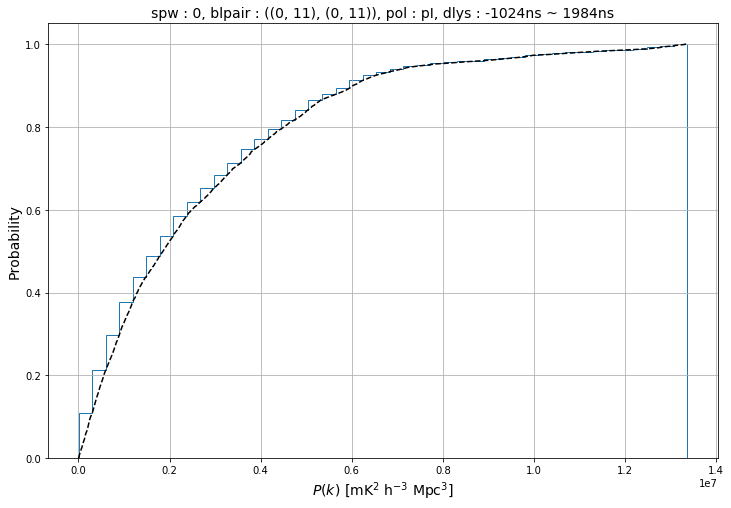

In [56]:
# cumulative distribution function
fig, ax = plt.subplots(figsize=(12,8))

spw = 0
blp = ((0, 11), (0, 11))
pol = 'pI'
dly = [-1000, 2000]
key = (spw, blp, pol)
ini_dly = int(get_delay(dly[0], key))
fin_dly = int(get_delay(dly[1], key))
txt = (spw, blp, pol, ini_dly, fin_dly)

p = power_hist(dly[0], dly[1], key)
cdf = np.array(range(len(p)))/float(len(p))

n, bins, patches = ax.hist(p, bins='auto', density=True, histtype='step', cumulative=True)
ax.plot(np.sort(p), cdf, 'k--')
# ax.hist(p, bins=bins, density=True, histtype='step', cumulative=-1)
ax.grid()
ax.set_xlabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_ylabel(r"Probability", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}, dlys : {}ns ~ {}ns".format(*txt), fontsize=14)

In [57]:
# fit the CDF to a lognormal CDF [failed]
def log_fct(x, mu, sigma):
    m = mu
    s = sigma
    return np.exp(-(np.log(x)-m)**2/(2*s**2))/(s*x*np.sqrt(2*np.pi))
popt, pcov = curve_fit(log_fct, np.sort(p), cdf)
perr = np.sqrt(np.diag(pcov))

# my_fitter = sp.data.fitter()
# my_fitter.set_functions(f='np.exp(-(np.log(x)-m)**2/(2*s**2))/(s*x*np.sqrt(2*np.pi))', p='m=184, s=90')
# my_fitter.set_data(xdata=np.sort(p), ydata=cdf, eydata=0.05)
# my_fitter.set(xlabel = 'P(k)', ylabel = 'Probability')
# my_fitter.fit()
# my_fitter.set(plot_guess = False, style_data = {'marker': '^', 'color': 'b', 'ls': '', 'mec': 'w'})
# sp.tweaks.ubertidy(font_size=10, keep_axis_labels = True, axis_label_font_size = 12)
# print(my_fitter)